In [1]:
import torch 
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import ncps 
from ncps.torch import LTC
from ncps.torch import CfC
from ncps.wirings import AutoNCP
import pytorch_lightning as pl
import torch.utils.data as data
import seaborn as sns

In [40]:
initial_point = np.array([10.61098536,  5.87720862, 34.48052002])
params = [10, 28, 8/3]
dt = 0.001
n_samples = 100000

def dpdt(point, params=params): #position

    x,y,z = point
    sig, rho, beta = params
    
    new_x = y*dt*sig + x*(1-dt*sig)
    new_y = x*dt*(rho-z) + y*(1-dt)
    new_z = x*y*dt + z*(1-dt*beta)
    return np.array([new_x, new_y, new_z])

# calculate trajectory
positions = []
positions.append(initial_point)

# your dataset
for i in range(n_samples):
    positions.append(dpdt(positions[-1]))

In [41]:
positions = np.stack(positions)
positions.shape


(100001, 3)

In [42]:
p_max = np.max(positions)
p_min = np.min(positions)

positions = positions+np.random.randn(100001,3) * 0.01

#positions = positions/p_max 

In [43]:
x = positions[:n_samples]
y = positions[1:n_samples+1]
y.shape
print(x[1], " ", y[0])

[10.56771182  5.81896096 34.45007737]   [10.56771182  5.81896096 34.45007737]


In [55]:
# LightningModule for training a RNNSequence module
class SequenceLearner(pl.LightningModule):
    def __init__(self, model, lr=0.005):
        super().__init__()
        self.model = model
        self.lr = lr

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat, _ = self.model.forward(x)
        y_hat = y_hat.view_as(y)
        loss = nn.MSELoss()(y_hat, y)
        self.log("train_loss", loss, prog_bar=True)
        return {"loss": loss}

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat, _ = self.model.forward(x)
        y_hat = y_hat.view_as(y)
        loss = nn.MSELoss()(y_hat, y)

        self.log("val_loss", loss, prog_bar=True)
        return loss

    def test_step(self, batch, batch_idx):
        # Here we just reuse the validation_step for testing
        return self.validation_step(batch, batch_idx)

    def configure_optimizers(self):
        return torch.optim.Adam(self.model.parameters(), lr=self.lr)

In [45]:
class MultiStepSeqLearner(pl.LightningModule):
    def __init__(self, model, length, lr=0.005):
        super().__init__()
        self.model = model
        self.lr = lr
        self.length = length

    def training_step(self, batch, batch_idx):
        ''' This is with the assumption that the batches will come in of something like 
        batch = (x, y) where x and y both have shape
        shape=(batch_size, trajectory_length, input_space)'''
        x, y = batch
        rolling_inputs = x
        predictions = []
        
        for i in range(self.length):
            
            prediction = world_model(rolling_inputs)[0]
                
            predictions.append(prediction)
            #print(prediction.unsqueeze(axis=1).shape)
            #print(rolling_inputs.shape)
            rolling_inputs = torch.concatenate((rolling_inputs, prediction.unsqueeze(axis=1)), axis=1)
        
        
        predictions = torch.stack(predictions)
        predictions = torch.swapaxes(predictions, 0, 1)
        #print(predictions.shape, " ", y.shape)
        #trajectory = trajectory.view_as(y)
        #print(trajectory.shape)
        loss = nn.MSELoss()(predictions, y)
        self.log("train_loss", loss, prog_bar=True)
        return {"loss": loss}
        
            
    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat, _ = self.model.forward(x)
        y_hat = y_hat.view_as(y)
        loss = nn.MSELoss()(y_hat, y)

        self.log("val_loss", loss, prog_bar=True)
        return loss

    def test_step(self, batch, batch_idx):
        # Here we just reuse the validation_step for testing
        return self.validation_step(batch, batch_idx)

    def configure_optimizers(self):
        return torch.optim.Adam(self.model.parameters(), lr=self.lr)

In [1]:
# now we have to make them into batches of sequence lengths
x = []
y = []
traj_len = 2
for i in range(n_samples//traj_len):
    x.append(positions[i:i+traj_len])
    y.append(positions[i + 1 + traj_len: i + 1 + 2*traj_len])

#print(x, y[0])
#print(" ")
#print(x, y[1])
x = np.stack(x)
y = np.stack(y)

NameError: name 'n_samples' is not defined

In [2]:
# now we have to make them into batches of sequence lengths
x = []
y = []
traj_len = 2
for i in range(n_samples):
    x.append(positions[i])
    y.append(positions[i + 1])

#print(x, y[0])
#print(" ")
#print(x, y[1])
x = np.stack(x)
y = np.stack(y)

NameError: name 'n_samples' is not defined

In [48]:
print(x.shape, " ", y.shape)

(100000, 3)   (100000, 3)


In [49]:
from ncps.wirings import NCP
out_features = 3
in_features = 3

#wiring = AutoNCP(6, out_features)  
wiring = NCP(inter_neurons=2 command_neurons=2, motor_neurons=out_features,
             sensory_fanout=4, inter_fanout=4, recurrent_command_synapses=4, motor_fanin=3)

world_model = LTC(in_features, wiring, batch_first=True, return_sequences=False) # change to cfc, what could go wrong?

In [50]:
learn = MultiStepSeqLearner(world_model, lr=5e-2, length=traj_len)

trainer = pl.Trainer(
    logger=pl.loggers.CSVLogger("log"),
    max_epochs=10,
    gradient_clip_val=1,  # Clip gradient to stabilize training
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [51]:
inputs = torch.tensor(x, dtype=torch.float32)
outputs = torch.tensor(y, dtype=torch.float32)

dataloader = data.DataLoader(
    data.TensorDataset(inputs, outputs), batch_size=128, shuffle=True, num_workers=24
)

In [52]:
trainer.fit(learn, dataloader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type | Params | Mode 
---------------------------------------
0 | model | LTC  | 815    | train
---------------------------------------
661       Trainable params
154       Non-trainable params
815       Total params
0.003     Total estimated model params size (MB)
4         Modules in train mode
0         Modules in eval mode


Training: |                                                                                       | 0/? [00:00…

RuntimeError: Sizes of tensors must match except in dimension 1. Expected size 128 but got size 3 for tensor number 1 in the list.

In [ ]:
inputs.shape

In [ ]:
x = positions[:n_samples]
y = positions[1:n_samples+1]
y.shape

In [ ]:
# NCPS Residuals
x_residuals = []
y_residuals = []
ang_vel_residuals = []

set_of_predictions = []

with torch.no_grad():
    prediction = world_model(inputs)[0].numpy()
print(prediction.shape)
# save predictions
#print("PRED: ", prediction)

set_of_predictions.append(prediction)

print(y.shape)

# get residuals
#x_residuals.append(prediction[:, 0] - y[:, 0])
#y_residuals.append(prediction[:, 1] - y[:, 1])
#ang_vel_residuals.append(prediction[:, 2] - y[:, 2])

#NCPS_x_res = np.stack(x_residuals).T
#NCPS_y_res = np.stack(y_residuals).T
#NCPS_ang_res = np.stack(ang_vel_residuals).T


In [ ]:
plt.scatter(prediction[:, 0], prediction[:, 1])
#set_of_predictions.shape

In [ ]:
sns.set()
plt.scatter(y[:, 0], y[:, 1], alpha=0.5, label="real")
plt.scatter(prediction[:, 0], prediction[:, 1], alpha=0.5, color='g', label="NCPS, one step")
plt.legend()
plt.title("NCPS, trained with 5-step look ahead")

In [ ]:
plt.scatter(y[:, 1], y[:, 2], alpha=0.5, label="real")
plt.scatter(prediction[:, 1], prediction[:, 2], alpha=0.5, color='g', label="NCPS, one step")
plt.legend()
plt.title("NCPS, trained with 5-step look ahead")

For my own sanity, I should start documenting what it is that I'm doing here.

In this case, what we have is that upon recieving real inputs with time correspondance to them, we can achieve pretty solid results. Now, I want to see what that our model looks like when we try to achieve more than one step prediction.

I see two paths forward here. If we set an arbitrary time window ahead and set our model to be unable to go past that line, then we would expect worse results as opposed to not having a time window at all. The upside then is then we reduce compute time. 

How much worse results, we can test for. How much worse compute time, probably not.

In [ ]:
# I'm experimenting with no time-window first.

rolling_inputs = inputs[0]
predictions = []

num_predictions = 500 

for i in range(num_predictions):
    with torch.no_grad():
        prediction = world_model(rolling_inputs)[0]
        
    predictions.append(prediction)
    #prediction = torch.FloatTensor(np.expand_dims(prediction, axis=0))
    rolling_inputs = torch.concatenate((rolling_inputs, prediction.unsqueeze(0)))


predictions = torch.stack(predictions)
#predictions


In [ ]:
inputs[0]

In [ ]:
y = np.double(y)
y[:5]
y[3]

In [ ]:
plt.scatter(y[3, 1], y[3, 0], label="y")
plt.scatter(inputs[0, :, 1], inputs[0, :, 0], alpha=0.5)
plt.legend()

In [ ]:
plt.scatter(predictions[:, 0], predictions[:, 1], alpha=0.5, color='g', label="NCPS, 500 Step")
plt.scatter(y[3: 3 + num_predictions, 0], y[3: 3 + num_predictions, 1], alpha=0.5, color='b', label="real")
plt.legend()
plt.title("NCPS, trained with 5-step look ahead")

In [ ]:
plt.scatter(predictions[:, 1], predictions[:, 2], color='g', label="NCPS, 500 Step")
plt.scatter(y[3: 3 + num_predictions, 1], y[3: 3 + num_predictions, 2], alpha=0.5, color='b', label="real")
plt.legend()
plt.title("NCPS, trained with 5-step look ahead")

In [ ]:
residual = y[3: 3 + num_predictions] - predictions.numpy()
residual.shape



In [ ]:
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(10, 10))
time_steps = np.arange(num_predictions)

# Define a function to plot the residuals on a given axis
def plot_residuals(ax, res, title):
    # Plot all individual rollouts
    #for r in range(res.shape[0]):
    ax.plot(res, color='blue', alpha=1, linewidth=1)
    
    # Compute and plot the mean
    #mean_rollout = res.mean(axis=0)
    #ax.plot(mean_rollout, color='blue', linewidth=2, label='Mean Rollout')
    
    # Compute and plot ±1 std dev
    #std_rollout = res.std(axis=0)
    #ax.fill_between(time_steps, mean_rollout - std_rollout, mean_rollout + std_rollout,
    #              color='blue', alpha=0.2, label='Mean ± 1 Std. Dev.')
    
    ax.set_xlabel("Time Step")
    ax.set_ylabel("Rollout Residual")
    ax.set_title(title)
    ax.legend(loc='upper right')

# Plot for x_res
plot_residuals(axes[0], residual[:, 0], "X Residual")

# Plot for y_res
plot_residuals(axes[1], residual[:, 1], "Y Residual")

# Plot for ang_res
plot_residuals(axes[2], residual[:, 2], "Angular Velocity Residual")

plt.tight_layout()
plt.show()

In [ ]:
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(10, 10))
time_steps = np.arange(num_predictions)

# Define a function to plot the residuals on a given axis
def plot_residuals(ax, res, title):
    # Plot all individual rollouts
    #for r in range(res.shape[0]):
    ax.plot(res, color='blue', alpha=1, linewidth=1)
    
    # Compute and plot the mean
    #mean_rollout = res.mean(axis=0)
    #ax.plot(mean_rollout, color='blue', linewidth=2, label='Mean Rollout')
    
    # Compute and plot ±1 std dev
    #std_rollout = res.std(axis=0)
    #ax.fill_between(time_steps, mean_rollout - std_rollout, mean_rollout + std_rollout,
    #              color='blue', alpha=0.2, label='Mean ± 1 Std. Dev.')
    
    ax.set_xlabel("Time Step")
    ax.set_ylabel("Rollout Residual")
    ax.set_title(title)
    #ax.legend(loc='upper right')

# Plot for x_res
plot_residuals(axes[0], predictions[:, 0], "X State Features")

# Plot for y_res
plot_residuals(axes[1], predictions[:, 1], "Y State Features")

# Plot for ang_res
plot_residuals(axes[2], predictions[:, 2], "Z State Features")

plt.tight_layout()
plt.show()

In [ ]:
# I'm experimenting with now we stick with a 20-step time-window. See how far into the future we can get.

rolling_inputs = inputs[0]
window = inputs.shape[1]
predictions = []

num_predictions = 10_000

for i in range(num_predictions):
    with torch.no_grad():
        prediction = world_model(rolling_inputs)[0]
        
    predictions.append(prediction)
    #prediction = torch.FloatTensor(np.expand_dims(prediction, axis=0))
    #print(rolling_inputs.shape[0])
    if rolling_inputs.shape[0] > window:
        rolling_inputs = torch.concatenate((rolling_inputs[1:window+1], prediction.unsqueeze(0)))
    else:
         rolling_inputs = torch.concatenate((rolling_inputs, prediction.unsqueeze(0)))


predictions = torch.stack(predictions)
predictions.shape


In [ ]:
plt.scatter(predictions[:, 1], predictions[:, 2], color='g', label="NCPS, 50_000 Step")
#plt.scatter(y[3: 3 + num_predictions, 1], y[3: 3 + num_predictions, 2], alpha=0.5, color='b', label="real")
plt.legend()
plt.title("NCPS, trained with 5-step look ahead")

Text(0.5, 1.0, 'NCPS, trained with 5-step look ahead')

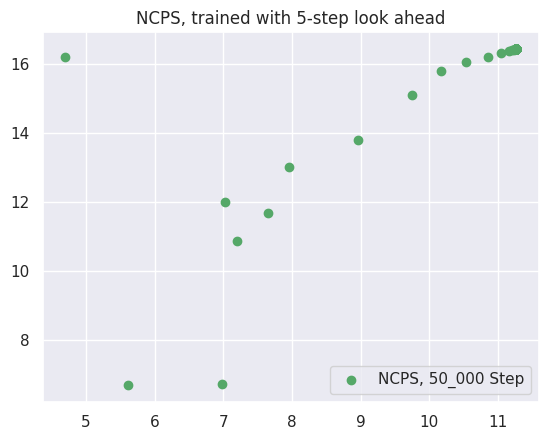

In [53]:
plt.scatter(predictions[:, 0], predictions[:, 1], color='g', label="NCPS, 50_000 Step")
#plt.scatter(y[3: 3 + num_predictions, 1], y[3: 3 + num_predictions, 2], alpha=0.5, color='b', label="real")
plt.legend()
plt.title("NCPS, trained with 5-step look ahead")

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


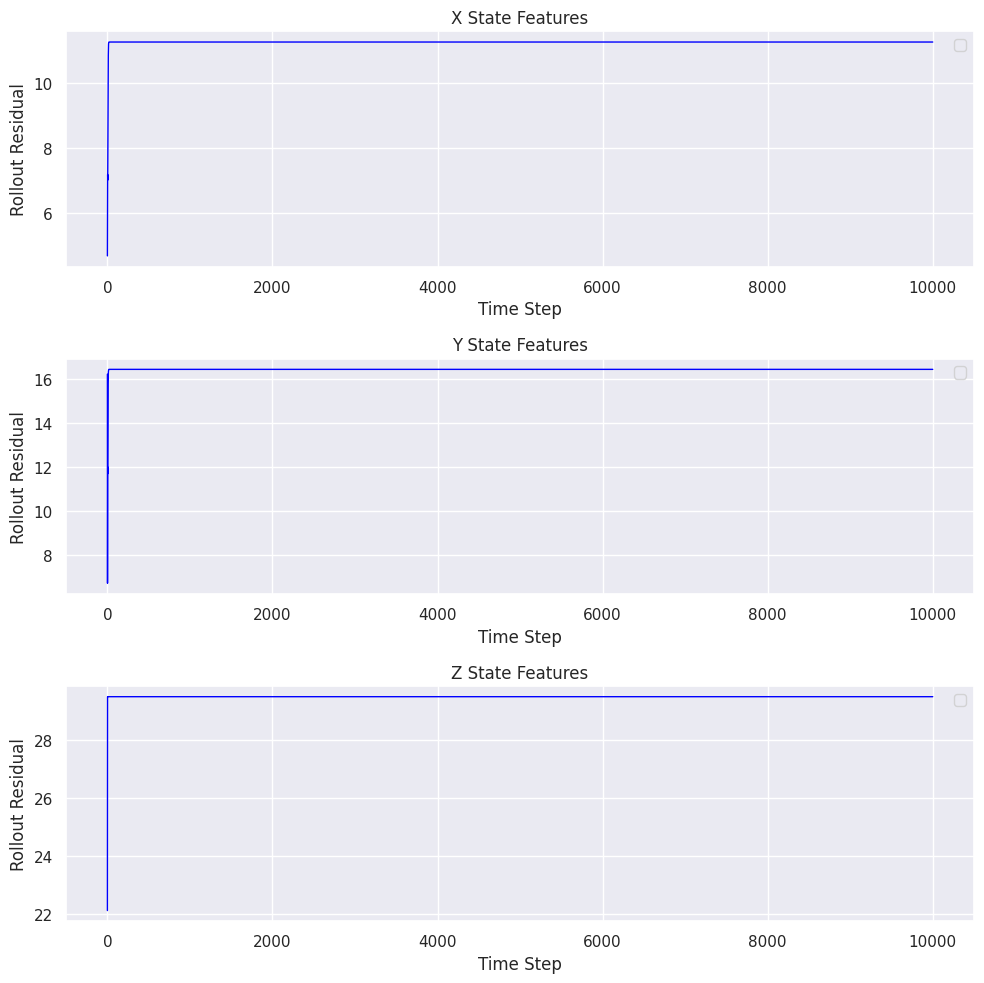

In [54]:
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(10, 10))
time_steps = np.arange(num_predictions)

# Define a function to plot the residuals on a given axis
def plot_residuals(ax, res, title):
    # Plot all individual rollouts
    #for r in range(res.shape[0]):
    ax.plot(res, color='blue', alpha=1, linewidth=1)
    
    # Compute and plot the mean
    #mean_rollout = res.mean(axis=0)
    #ax.plot(mean_rollout, color='blue', linewidth=2, label='Mean Rollout')
    
    # Compute and plot ±1 std dev
    #std_rollout = res.std(axis=0)
    #ax.fill_between(time_steps, mean_rollout - std_rollout, mean_rollout + std_rollout,
    #              color='blue', alpha=0.2, label='Mean ± 1 Std. Dev.')
    
    ax.set_xlabel("Time Step")
    ax.set_ylabel("Rollout Residual")
    ax.set_title(title)
    ax.legend(loc='upper right')

# Plot for x_res
plot_residuals(axes[0], predictions[:, 0], "X State Features")

# Plot for y_res
plot_residuals(axes[1], predictions[:, 1], "Y State Features")

# Plot for ang_res
plot_residuals(axes[2], predictions[:, 2], "Z State Features")

plt.tight_layout()
plt.show()